In [165]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

""" 1. Contest data """
# A
data_csv = pd.read_csv("C:contestants.csv", header=0)
data_csv.set_index('to_country_id', drop=False)
comp_num = data_csv.groupby('to_country_id')['place_final'].count()
place_median = data_csv.groupby('to_country_id')['place_final'].median()
num_first = data_csv[data_csv['place_final'] == 1].groupby('to_country_id')['place_final'].count()
prec = num_first / comp_num * 100
final_data = pd.concat([comp_num, place_median, num_first, prec], axis='columns',
                       keys=['compete_num', 'plac_final_med', 'first_place_num', 'first_place_for_compete'])
final_data.fillna(value=0, inplace=True)
final_data.sort_values(by='first_place_for_compete', inplace=True, ascending=False)
final_data

,compete_num,plac_final_med,first_place_num,first_place_for_compete
to_country_id,,,,
ua,18,6.0,3.0,16.666667
ie,45,7.0,7.0,15.555556
lu,37,9.0,5.0,13.513514
se,61,7.0,7.0,11.475410
il,38,8.5,4.0,10.526316
...,...,...,...,...
al,11,17.0,0.0,0.000000
Ukraine,0,0.0,0.0,0.000000
Turkey,0,0.0,0.0,0.000000


In [166]:
# b
artists = data_csv.groupby('performer').count()
print(f"The performer that compete more than 3 times is: {'  -'.join(artists[artists['year'] > 3].index.tolist())}")

The performer that compete more than 3 times is: Fud Leclerc


In [167]:
# c
composers = data_csv.groupby('composers').count()
print(
    f"The composers that composed more than 3 songs are: {'  -'.join(composers[composers['year'] > 3].index.tolist())}")

The composers that composed more than 3 songs are: Andrej Babić  -André Popp  -Arne Bendiksen  -Brendan J. Graham  -Dimitris Kontopoulos  -Dimitris Kontopoulos;Philipp Kirkorov  -Domenico Modugno  -Géo Voumard  -Hubert Giraud  -Juan Carlos Calderón  -Lasse Holm  -Marc Paelinck  -Matjaž Vlašič  -Nikos Terzis  -Paul Quintens  -Peter Reber  -Philip Vella  -Ralph Siegel  -Rolf Løvland  -Sven Lõhmus  -Søren Bundgaard  -Tonči Huljić  -Udo Jürgens  -Željko Joksimović


In [168]:
# d
israel_placing = data_csv[data_csv['to_country'] == 'Israel']['place_final'].value_counts().sort_values(ascending=False)
print(f"Israel placing: \n{israel_placing}")

Israel placing: 
place_final
1.0     4
7.0     3
23.0    3
11.0    2
6.0     2
2.0     2
5.0     2
19.0    2
8.0     2
12.0    2
3.0     2
16.0    2
9.0     2
14.0    2
4.0     2
18.0    1
24.0    1
22.0    1
17.0    1
Name: count, dtype: int64


In [169]:
""" 2. Creating dictionary to convert Country's name from short to long """
codeToCountry = data_csv[['to_country_id', 'to_country']]
codeToCountry = codeToCountry.drop_duplicates(keep='first', ignore_index=True)
codes = codeToCountry['to_country_id'].to_frame()
names = codeToCountry['to_country'].to_frame()

code_to_country = {}
for key, value in zip(codes.values, names.values):
    code_to_country[key[0]] = value[0]
code_to_country['ad'] = 'Audience'
code_to_country['wld'] = 'World'
code_to_country

{'ch': 'Switzerland',
 'nl': 'Netherlands',
 'be': 'Belgium',
 'de': 'Germany',
 'fr': 'France',
 'lu': 'Luxembourg',
 'it': 'Italy',
 'dk': 'Denmark',
 'gb': 'United Kingdom',
 'at': 'Austria',
 'se': 'Sweden',
 'mc': 'Monaco',
 'no': 'Norway',
 'yu': 'Yugoslavia',
 'es': 'Spain',
 'fi': 'Finland',
 'pt': 'Portugal',
 'ie': 'Ireland',
 'mt': 'Malta',
 'il': 'Israel',
 'gr': 'Greece',
 'tr': 'Turkey',
 'ma': 'Morocco',
 'cy': 'Cyprus',
 'is': 'Iceland',
 'hr': 'Croatia',
 'ba': 'Bosnia & Herzegovina',
 'si': 'Slovenia',
 'pl': 'Poland',
 'hu': 'Hungary',
 'ru': 'Russia',
 'sk': 'Slovakia',
 'ro': 'Romania',
 'ee': 'Estonia',
 'lt': 'Lithuania',
 'mk': 'North MacedoniaN.Macedonia',
 'lv': 'Latvia',
 'ua': 'Ukraine',
 'cs': 'Serbia & Montenegro',
 'al': 'Albania',
 'Estonia': 'Estonia',
 'Israel': 'Israel',
 'Denmark': 'Denmark',
 'Finland': 'Finland',
 'Portugal': 'Portugal',
 'Lithuania': 'Lithuania',
 'Latvia': 'Latvia',
 'Andorra': 'Andorra',
 'Belarus': 'Belarus',
 'Monaco': 'Monaco

In [170]:
""" 3. Analysis of the politicization of the Eurovision """
votes = pd.read_csv(
    "C:votes.csv",
    header=0)
votes.drop(votes[votes['round'] != 'final'].index, inplace=True)
votes['from_country_id'] = votes['from_country_id'].apply(lambda x: code_to_country[x])
votes['to_country_id'] = votes['to_country_id'].apply(lambda x: code_to_country[x])
comp_num.rename(code_to_country, inplace=True)
comp_over_30 = comp_num[comp_num >= 30]
drop_index_to = votes.loc[votes['to_country_id'].apply(lambda x: x not in comp_over_30)].index
votes.drop(index=drop_index_to, inplace=True)
drop_index_from = votes.loc[votes['from_country_id'].apply(lambda x: x not in comp_over_30)].index
votes.drop(index=drop_index_from, inplace=True)
votes = votes[~((votes['jury_points'].isna()) & (votes['year'] > 1996))]
votes.loc[votes['year'] > 1996, 'total_points'] = votes.loc[votes['year'] > 1996, 'jury_points']
votes.rename(columns={'from_country_id': 'from', 'to_country_id': 'to', 'total_points': 'points'}, inplace=True)
votes.drop(columns=[x for x in votes.columns if x not in ['year', 'from', 'to', 'points']], inplace=True)
votes

,year,from,to,points
0,1957,Austria,Netherlands,6
1,1957,Austria,France,0
2,1957,Austria,Denmark,0
3,1957,Austria,Luxembourg,3
4,1957,Austria,Germany,0
...,...,...,...,...
51318,2023,United Kingdom,Spain,5
51321,2023,United Kingdom,Switzerland,0
51324,2023,United Kingdom,Portugal,0
51326,2023,United Kingdom,United Kingdom,0


In [171]:
# mean
mean_points = votes.groupby(['year', 'to'])['points'].mean().reset_index()
mean_points.rename(columns={'to': 'country', 'points': 'mean_points'}, inplace=True)
mean_points['year.country'] = mean_points['year'].astype(str) + '.' + mean_points['country']
mean_points.set_index('year.country', inplace=True)
mean_points

,year,country,mean_points
year.country,,,
1957.Austria,1957,Austria,0.300000
1957.Belgium,1957,Belgium,0.500000
1957.Denmark,1957,Denmark,1.000000
1957.France,1957,France,1.700000
1957.Germany,1957,Germany,0.800000
...,...,...,...
2023.Portugal,2023,Portugal,1.611111
2023.Spain,2023,Spain,2.500000
2023.Sweden,2023,Sweden,9.277778


In [172]:
# norm
votes = votes.merge(mean_points, left_on=['year', 'to'], right_on=['year', 'country'])
votes['adjusted_points'] = votes['points'] - votes['mean_points']
votes['above_average'] = votes['adjusted_points'] > 0
votes.loc[votes['from'] == votes['to'], 'above_average'] = True
from_to_above_average = votes.groupby(['from', 'to'])['above_average'].mean().unstack(fill_value=0)
from_to_above_average

to,Austria,Belgium,Cyprus,Denmark,Finland,France,Germany,Greece,Ireland,Israel,Italy,Luxembourg,Netherlands,Norway,Portugal,Spain,Sweden,Switzerland,Turkey,United Kingdom
from,,,,,,,,,,,,,,,,,,,,
Austria,1.000000,0.179487,0.142857,0.300000,0.117647,0.487805,0.268293,0.181818,0.666667,0.391304,0.333333,0.387097,0.447368,0.236842,0.151515,0.342105,0.410256,0.473684,0.117647,0.487805
Belgium,0.447368,1.000000,0.300000,0.233333,0.162162,0.386364,0.511111,0.181818,0.580645,0.423077,0.463415,0.305556,0.238095,0.390244,0.222222,0.357143,0.309524,0.404762,0.222222,0.533333
Cyprus,0.315789,0.315789,1.000000,0.250000,0.222222,0.571429,0.238095,1.000000,0.266667,0.277778,0.562500,0.416667,0.222222,0.238095,0.150000,0.409091,0.318182,0.222222,0.000000,0.136364
Denmark,0.387097,0.250000,0.421053,1.000000,0.230769,0.303030,0.529412,0.222222,0.473684,0.142857,0.100000,0.240000,0.266667,0.500000,0.160000,0.133333,0.718750,0.433333,0.062500,0.484848
Finland,0.176471,0.342105,0.400000,0.320000,1.000000,0.384615,0.150000,0.409091,0.266667,0.600000,0.583333,0.375000,0.289474,0.250000,0.222222,0.268293,0.589744,0.315789,0.235294,0.439024
France,0.315789,0.333333,0.200000,0.344828,0.194444,1.000000,0.363636,0.454545,0.333333,0.458333,0.425000,0.411765,0.487805,0.275000,0.514286,0.414634,0.292683,0.341463,0.176471,0.477273
Germany,0.263158,0.348837,0.150000,0.200000,0.189189,0.500000,1.000000,0.000000,0.483871,0.461538,0.341463,0.388889,0.500000,0.365854,0.250000,0.404762,0.452381,0.428571,0.235294,0.377778
Greece,0.409091,0.304348,0.944444,0.176471,0.272727,0.480000,0.160000,1.000000,0.526316,0.045455,0.363636,0.250000,0.363636,0.120000,0.500000,0.538462,0.240000,0.272727,0.000000,0.230769
Ireland,0.400000,0.342857,0.400000,0.333333,0.333333,0.555556,0.405405,0.136364,1.000000,0.480000,0.406250,0.535714,0.529412,0.416667,0.171429,0.263158,0.388889,0.441176,0.176471,0.473684


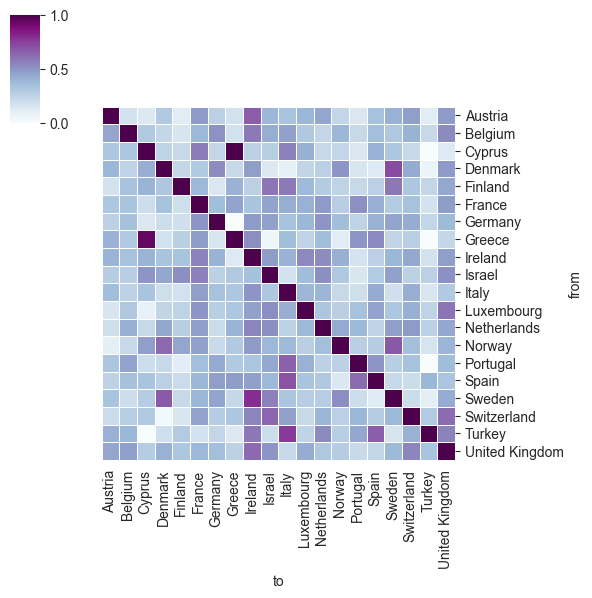

In [176]:
""" 4. Create a matrix of scoring countries(rows) to scoring countries (columns) """
sns.clustermap(from_to_above_average, figsize=(6, 6), row_cluster=False, col_cluster=False, cmap='BuPu', linewidths=.6, linecolor='white')
plt.show()

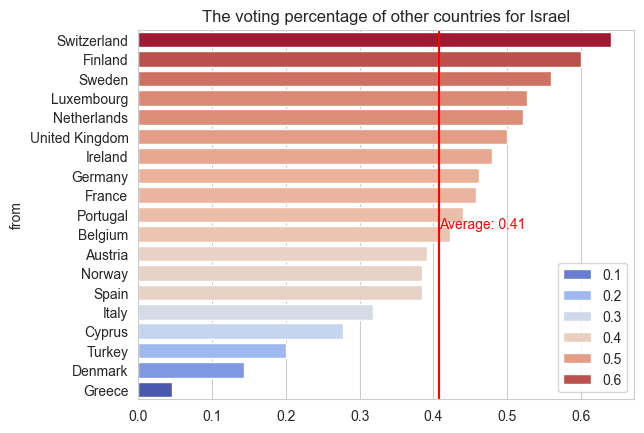

In [174]:
# B
israel = from_to_above_average['Israel'].drop('Israel').sort_values(ascending=False)
sns.barplot(x=israel.values, y=israel.index, palette='coolwarm', hue=israel.values)
mean_value = israel.mean()
plt.axvline(mean_value, color='r', linestyle='-')
plt.text(mean_value, len(israel) / 2, f'Average: {mean_value:.2f}', color='r', va='center')
plt.title("The voting percentage of other countries for Israel")
plt.show()

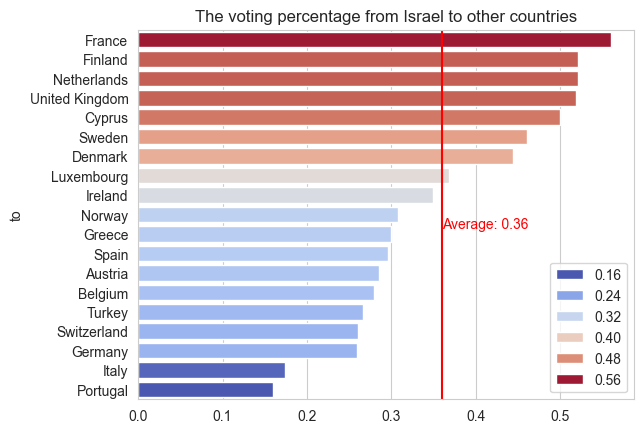

In [175]:
# C
israel = from_to_above_average.loc['Israel'].drop('Israel').sort_values(ascending=False)
sns.barplot(x=israel.values, y=israel.index, palette='coolwarm', hue=israel.values)
mean_value = israel.mean()
plt.axvline(mean_value, color='r', linestyle='-')
plt.text(mean_value, len(israel) / 2, f'Average: {mean_value:.2f}', color='r', va='center')
plt.title("The voting percentage from Israel to other countries")
plt.show()
